# **Stokes**
This lab focuses on performing the Stokes **high fidelity equation**.

In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim
from scipy.sparse.linalg import splu
import time

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

## The parametric version of the heat conductivity equation

Solve the Stokes equation on square ${\Omega} = (0, 1) \times (0, 1)$

$$
\begin{cases}
-\nu \nabla \cdot (\nabla \mathbf{u}) + \nabla p = \mathbf{f} & \text{in } \Omega\\
(\nabla \cdot \mathbf{u}) = 0 & \text{in } \Omega\\
u = 0 & \text{in } ∂ \Omega
\end{cases}
$$

where $\nu$ is the **viscosity**, $\mathbf{u} = (u_1, u_2)$ is the **speed** and $p$ is the **pressure**.

In [ ]:
def Stokes_V(): # The viscosity is fixed to 1
	return 1.0

# All the other part of the equations  
def Stokes_v(numPoints, points):
	values = np.ones(numPoints) * Stokes_V()
	return values.ctypes.data

def Stokes_advection_1(numPoints, points):
	values = np.zeros((2, numPoints), order='F')
	values[0,:] = 1.0
	return values.ctypes.data

def Stokes_advection_2(numPoints, points):
	values = np.zeros((2, numPoints), order='F')
	values[1,:] = 1.0
	return values.ctypes.data

def Stokes_f_1(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = - (+8.0 * np.pi * np.pi * np.cos(4.0 * np.pi * matPoints[0,:]) - 4.0 * np.pi * np.pi) *
		np.sin(2.0 * np.pi * matPoints[1,:]) * np.cos(2.0 * np.pi * matPoints[1,:]) + (+2.0 * np.pi * 
		np.cos(2.0 * np.pi * matPoints[0,:]) * np.cos(2.0 * np.pi * matPoints[1,:]))
	return values.ctypes.data

def Stokes_f_2(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = - (-8.0 * np.pi * np.pi * np.cos(4.0 * np.pi * matPoints[1,:]) + 4.0 * np.pi * np.pi) * 
		np.sin(2.0 * np.pi * matPoints[0,:]) * np.cos(2.0 * np.pi * matPoints[0,:]) + (-2.0 * np.pi * 
		np.sin(2.0 * np.pi * matPoints[0,:]) * np.sin(2.0 * np.pi * matPoints[1,:]))
	return values.ctypes.data

# We put the exact solution in order to understand which is the error that we compute
# solving this equation in this manner
def Stokes_pressure_exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.sin(2.0 * np.pi * matPoints[0,:]) * np.cos(2.0 * np.pi * matPoints[1,:])
	return values.ctypes.data

def Stokes_speed_exactSolution_1(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = +0.5 * np.sin(2.0 * np.pi * matPoints[0,:]) * np.sin(2.0 * np.pi * matPoints[0,:]) * 
		np.sin(2.0 * np.pi * matPoints[1,:]) * np.cos(2.0 * np.pi * matPoints[1,:])
	return values.ctypes.data

def Stokes_speed_exactSolution_2(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = -0.5 * np.sin(2.0 * np.pi * matPoints[1,:]) * np.sin(2.0 * np.pi * matPoints[1,:]) * 
		np.sin(2.0 * np.pi * matPoints[0,:]) * np.cos(2.0 * np.pi * matPoints[0,:])
	return values.ctypes.data

### Discretization

In [ ]:
# Discetizatoin of the mesh fixing the size
order = 1 # In this case we have to fix to different order ... 
meshSize = 0.001

# ... Hence this is just a representation of the mesh, in the next line of code, 
# we'll define different orders for the pressure & velocity
# following the Taylor-Hood finite element strategy

In [ ]:
# We fix the constant (4 points) to have just one solution
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [2,3,4,5], 
          'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }

[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

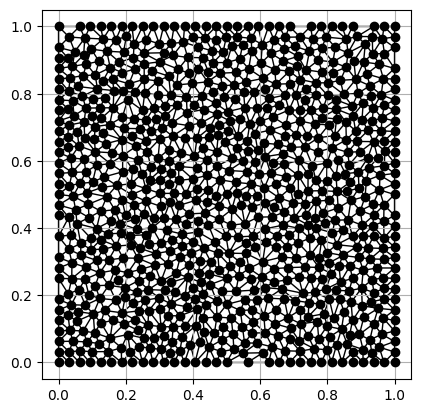

In [17]:
gedim.PlotMesh(mesh)

### High Fidelity approximation

In [ ]:
# ... Indeed, here we select to different order for pressure and velocity in accordance with the theory (Taylor-Hood)
pressure_discreteSpace = { 'Order': 1, 'Type': 1, 'BoundaryConditionsType': [1, 2, 1, 1, 1, 1] } # Pressure order 1
speed_discreteSpace = { 'Order': 2, 'Type': 1, 'BoundaryConditionsType': [1, 2, 2, 2, 2, 2] } # Velocity order 2

# Discretization of the space wrt the order that we select for the different variable
[pressure_problemData, pressure_dofs, pressure_strongs] = gedim.Discretize(pressure_discreteSpace, lib)
[speed_problemData, speed_dofs, speed_strongs] = gedim.Discretize(speed_discreteSpace, lib)

In [ ]:
# Pressure
pressure_n_dofs = pressure_problemData['NumberDOFs']
pressure_n_strongs = pressure_problemData['NumberStrongs']

# Velocity (speed)
speed_n_dofs = speed_problemData['NumberDOFs']
speed_n_strongs = speed_problemData['NumberStrongs']

In [ ]:
# As exprect, the results for the dregrees of freedom
# are different wrt the order that we have choice in 
# pressure_discreteSpace & speed_discreteSpace
print(f"Degrees of fredom for the pressure: {pressure_n_dofs}") 
print(f"Degrees of fredom for the velocity: {speed_n_dofs}")

# Notice that this change wrt the meshSize that we put

Degrees of fredom for the pressure: 826
Degrees of fredom for the velocity: 2966


In [ ]:
# We need to decouple the velocity and the pressure because are two different variables: velocity & pressure

# Bilinear form a( , ) -- STRIFFNESS
# Stokes_v = nu
# In Stifness I have to pass only speed_probemData, because a: V x V --> R
[J_X_1, J_X_D_1] = gedim.AssembleStiffnessMatrix_Shift(speed_problemData['SpaceIndex'], speed_problemData['SpaceIndex'],
        Stokes_v, 2 * speed_n_dofs + pressure_n_dofs, 2 * speed_n_dofs + pressure_n_dofs,
        2 * speed_n_strongs + pressure_n_strongs, 0, 0, 0, lib)
[J_X_2, J_X_D_2] = gedim.AssembleStiffnessMatrix_Shift(speed_problemData['SpaceIndex'], speed_problemData['SpaceIndex'],
        Stokes_v, 2 * speed_n_dofs + pressure_n_dofs, 2 * speed_n_dofs + pressure_n_dofs, 
        2 * speed_n_strongs + pressure_n_strongs, 
        speed_n_dofs, speed_n_dofs, speed_n_strongs, lib)

# Bilinear form b( , ) -- ADVECTION 
# Here, we pass speed_problemData & pressure_problemData because we have two different variable to take in account
# Indeed, b: V x Q --> R
[J_B_1, J_B_D_1] = gedim.AssembleAdvectionMatrix_Shift(speed_problemData['SpaceIndex'], pressure_problemData['SpaceIndex'], 
        Stokes_advection_1, 2 * speed_n_dofs + pressure_n_dofs, 2 * speed_n_dofs + pressure_n_dofs,
        2 * speed_n_strongs + pressure_n_strongs, 
        2 * speed_n_dofs, 0, 0, lib)
[J_B_2, J_B_D_2] = gedim.AssembleAdvectionMatrix_Shift(speed_problemData['SpaceIndex'], pressure_problemData['SpaceIndex'],
        Stokes_advection_2, 2 * speed_n_dofs + pressure_n_dofs, 2 * speed_n_dofs + pressure_n_dofs,
        2 * speed_n_strongs + pressure_n_strongs, 
        2 * speed_n_dofs, speed_n_dofs, speed_n_strongs, lib)

# Forcing term
J_f_1 = gedim.AssembleForcingTerm(Stokes_f_1, speed_problemData, lib)
J_f_2 = gedim.AssembleForcingTerm(Stokes_f_2, speed_problemData, lib)
J_f = np.concatenate([J_f_1, J_f_2, np.zeros(pressure_n_dofs)])

p_D = gedim.AssembleStrongSolution(Stokes_pressure_exactSolution, 1, pressure_problemData, lib)

In [ ]:
# Concatenate all the matrix and compute the solution (this is an algebric sum) remembering the definition
# of the problem the that we gave (Lesson 12 for more details)
solution = gedim.LUSolver(J_X_1 + J_X_2 - J_B_1 - J_B_2 - np.transpose(J_B_1) - np.transpose(J_B_2), J_f, lib)

u = solution[0:2 * speed_n_dofs]
p = solution[2 * speed_n_dofs:]

In [ ]:
# Compute the error
p_error_L2 = gedim.ComputeErrorL2(Stokes_pressure_exactSolution, p, p_D, lib, pressure_problemData)

print("dofs", "h", "pressure_errorL2")
print(2 * speed_n_dofs + pressure_n_dofs, '{:.16e}'.format(pressure_problemData['H']), '{:.16e}'.format(p_error_L2))

dofs h pressure_errorL2
6758 6.4341029499729044e-02 2.8969305492093154e-03


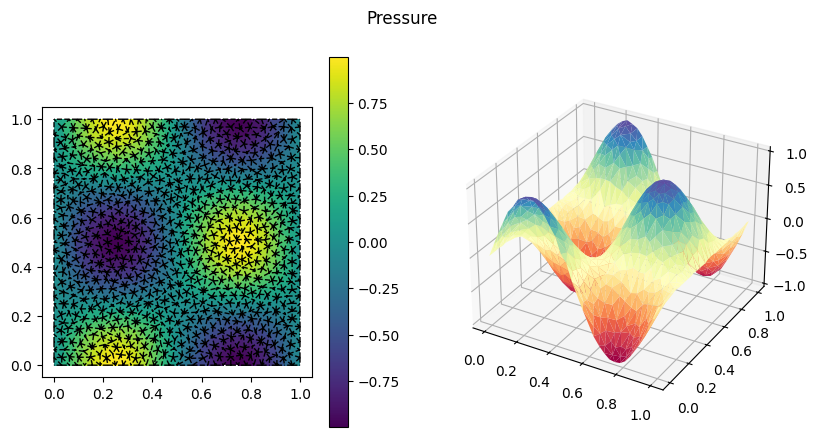

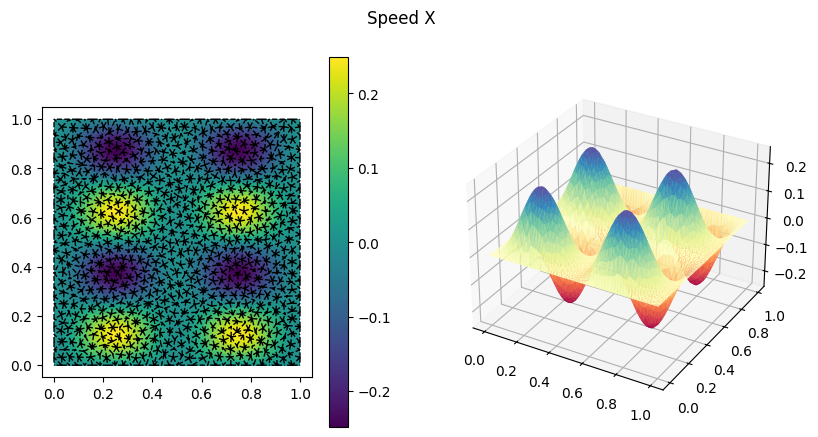

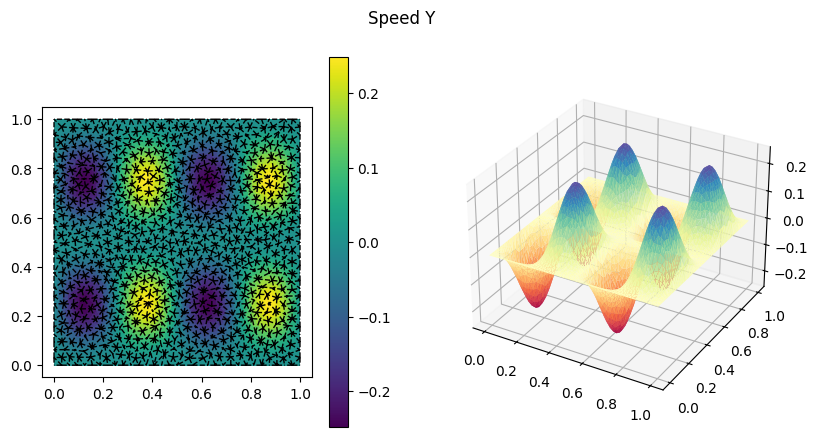

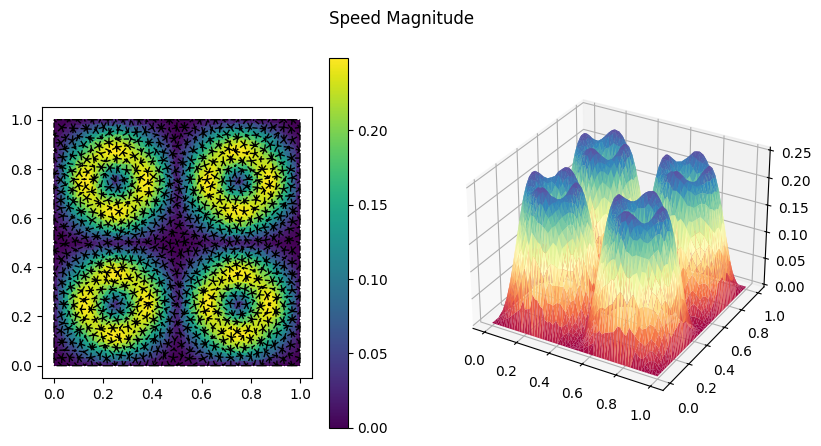

In [ ]:
# Plot the solution
gedim.PlotSolution(mesh, pressure_dofs, pressure_strongs, p, p_D, "Pressure")
gedim.PlotSolution(mesh, speed_dofs, speed_strongs, u[0:speed_n_dofs], np.zeros(speed_n_strongs), "Speed X")
gedim.PlotSolution(mesh, speed_dofs, speed_strongs, u[speed_n_dofs:], np.zeros(speed_n_strongs), "Speed Y")

# This is the magnitude plot for the velocity sqrt(x^2+y^2)
# Here the velocity is rotating (you can see for vortex)
gedim.PlotSolution(mesh, speed_dofs, speed_strongs, np.sqrt(u[0:speed_n_dofs] * u[0:speed_n_dofs] + u[speed_n_dofs:] * u[speed_n_dofs:]),
                    np.zeros(speed_n_strongs), "Speed Magnitude")

### Supremizer Operator
🧠 **Supremizer meaning**

In the context of numerical methods for PDE, in particular the **Stokes** (or Navier-Stokes) problem, we have a system of the type:

$$
\begin{cases}
-\nu \Delta \mathbf{u} + \nabla p = \mathbf{f} \\
\nabla \cdot \mathbf{u} = 0
\end{cases}
$$

where:
- $\mathbf{u}$: velocity field
- $p$: pressure
- $\nu$: viscosity

---
⚠️ **The problem: the inf-sup** condition

In the finite element method, a **good choice of discrete spaces** for velocity and pressure is needed to solve the problem correctly. A condition called the **inf-sup condition (or LBB condition)** must apply:

$$

\inf_{q \in Q} \sup_{\mathbf{v} \ in V} \frac{(\nabla \cdot \mathbf{v}, q)}{\sup_{\mathbf{v} \in Q}} \geq \beta > 0

$$

If **this condition is not met**, the system may be **unstable** or **unconditioned**.

---

✅ **The Role of the Supremizer**

A **supremizer** is an auxiliary (speed) function built to **stabilise** the system. The idea is to find a function $ \mathbf{u}_s \in V $ such that:

$$
(\mathbf{u}_s, \mathbf{v}) = (q, \nabla \cdot \mathbf{v}) \quad \forall \mathbf{v} \in V
$$

In practice:
- **Maps the pressure in a velocity space**.
- Used to construct stabilised spaces (e.g. in methods such as **P1-P1** where pressure and velocity have the same degree of approximation).
- Helps ensure that the numerical solution is **physically consistent** (conservation of mass, numerical stability).

---
The **supremizer** is calculated by solving:

$$
(X_1 + X_2)\mathbf{u}_s = (B_1 + B_2)^T p
$$

i.e., a **discrete** form of the pressure-velocity relation, where \(\mathbf{u}_s\) is the **supremizer field**.

In [ ]:
# Build matrices
[X_1, XStrong_1] = gedim.AssembleStiffnessMatrix_Shift(speed_problemData['SpaceIndex'], speed_problemData['SpaceIndex'], 
        Stokes_v, 2 * speed_n_dofs, 2 * speed_n_dofs, 2 * speed_n_strongs, 0, 0, 0, lib)
[X_2, XStrong_2] = gedim.AssembleStiffnessMatrix_Shift(speed_problemData['SpaceIndex'], speed_problemData['SpaceIndex'],
        Stokes_v, 2 * speed_n_dofs, 2 * speed_n_dofs, 2 * speed_n_strongs, speed_n_dofs, speed_n_dofs, speed_n_strongs, lib)

[B_1, BStrong_1] = gedim.AssembleAdvectionMatrix_Shift(speed_problemData['SpaceIndex'], pressure_problemData['SpaceIndex'], 
        Stokes_advection_1, pressure_n_dofs, 2 * speed_n_dofs, 2 * speed_n_strongs, 0, 0, 0, lib)
[B_2, BStrong_2] = gedim.AssembleAdvectionMatrix_Shift(speed_problemData['SpaceIndex'], pressure_problemData['SpaceIndex'],
        Stokes_advection_2, pressure_n_dofs, 2 * speed_n_dofs, 2 * speed_n_strongs, 0, speed_n_dofs, speed_n_strongs, lib)

In [ ]:
# Solve the problem with the supermizer operator
supremizer = gedim.LUSolver(X_1 + X_2, np.transpose(B_1 + B_2) @ p, lib)

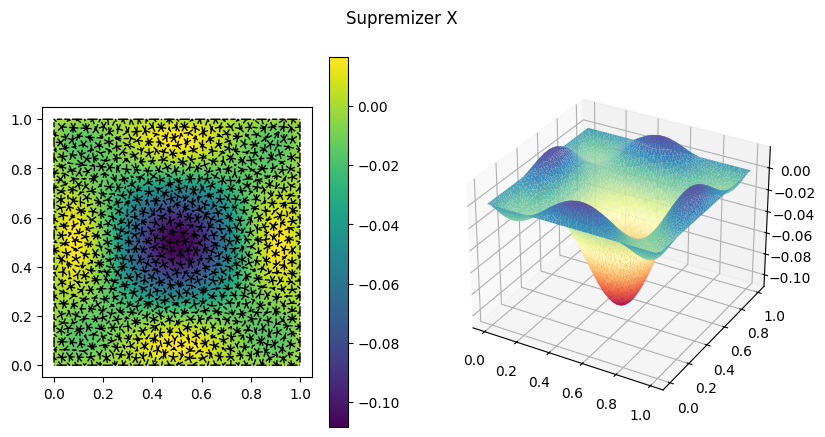

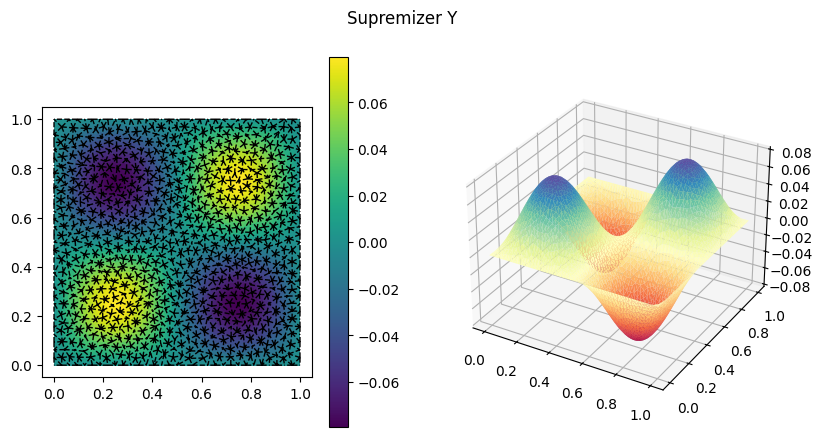

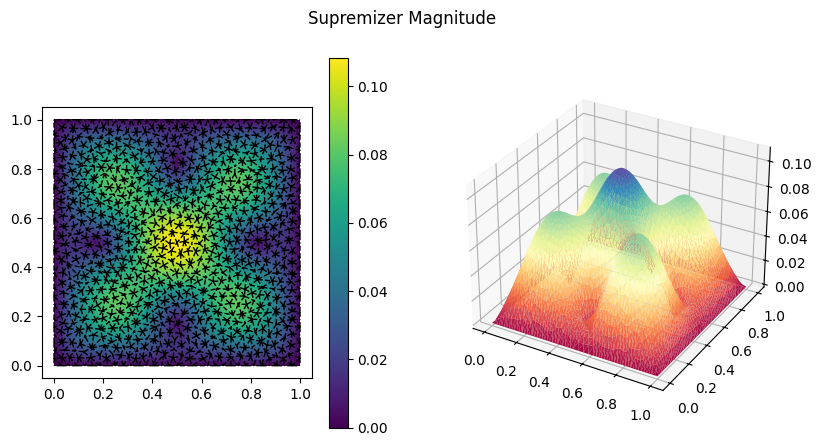

In [ ]:
# Plot the solutions
gedim.PlotSolution(mesh, speed_dofs, speed_strongs, supremizer[0:speed_n_dofs], np.zeros(speed_n_strongs), "Supremizer X")
gedim.PlotSolution(mesh, speed_dofs, speed_strongs, supremizer[speed_n_dofs:], np.zeros(speed_n_strongs), "Supremizer Y")
gedim.PlotSolution(mesh, speed_dofs, speed_strongs, np.sqrt(supremizer[0:speed_n_dofs] * supremizer[0:speed_n_dofs] 
                            + supremizer[speed_n_dofs:] 
                            * supremizer[speed_n_dofs:]), np.zeros(speed_n_strongs), "Supremizer Magnitude")

🧠 **Interpretation of results**
The supremizer is a vector field that “reinforces” the compatibility between velocity and pressure space, so its structure can reveal where the stability problem is most critical.

The X and Y components show the direction and intensity of the supremizer in the two axes.

The final root product can highlight areas where the two components are both relevant or where they interact in interesting ways.